### Função

In [ ]:

import os
def read_directories(directory, img=None):
    # Get a list of filenames in the specified directory
    filenames = []
    for filename in os.listdir(directory):
        if img is not None:
            # If 'img' is provided, filter filenames containing it
            if img in filename:   
                filenames.append(filename)          
        else:
            filenames.append(filename)    
    return filenames

### Diretório das imagens

In [ ]:

dir_images_atlas = f'work1/atlas'
dir_images_denoising_non_local_means = f'work1/denoising/non_local_means/images_filtered'
dir_out_resampled = f'work1/atlas_resampled'
dir_atlas_resampled = f'work1/atlas_resampled/IXI002-Guys-0828-T1.nii.gz'


array_images_atlas = read_directories(dir_images_atlas)
array_images_denoising = read_directories(dir_images_denoising_non_local_means)
array_dir_outputs = read_directories(dir_out_resampled)
array_dir_atlas_resampled = read_directories(dir_atlas_resampled)


print(array_images_atlas)
print(array_images_denoising)
print(array_dir_outputs)

### Função que muda a direção, orientação, size, origem de uma imagem móvel a partir de uma imagem de referência

In [ ]:
import SimpleITK as sitk
import numpy as np

# Função para reamostrar a imagem, ajustando resolução, tamanho e propriedades
def resample_image(itk_image, out_spacing, out_size=None, reference_image=None, is_label=False):
    resample = sitk.ResampleImageFilter()

    # Define o tamanho e o espaçamento
    if reference_image is not None:
        # Usa as propriedades da imagem de referência
        resample.SetSize(reference_image.GetSize())
        resample.SetOutputSpacing(reference_image.GetSpacing())
        resample.SetOutputDirection(reference_image.GetDirection())
        resample.SetOutputOrigin(reference_image.GetOrigin())
    else:
        original_spacing = itk_image.GetSpacing()
        original_size = itk_image.GetSize()
        if out_size is None:
            # Calcula o novo tamanho baseado no espaçamento
            out_size = [
                int(np.round(original_size[0] * (original_spacing[0] / out_spacing[0]))),
                int(np.round(original_size[1] * (original_spacing[1] / out_spacing[1]))),
                int(np.round(original_size[2] * (original_spacing[2] / out_spacing[2])))
            ]
        resample.SetSize(out_size)
        resample.SetOutputSpacing(out_spacing)
        resample.SetOutputDirection(itk_image.GetDirection())
        resample.SetOutputOrigin(itk_image.GetOrigin())

    # Configurações gerais do filtro
    resample.SetTransform(sitk.Transform())
    resample.SetDefaultPixelValue(itk_image.GetPixelIDValue())

    # Escolhe o interpolador com base no tipo da imagem
    if is_label:
        resample.SetInterpolator(sitk.sitkNearestNeighbor)
    else:
        resample.SetInterpolator(sitk.sitkBSpline)

    return resample.Execute(itk_image)

## Execução da função que faz as modificações nas imagens móveis a partir das imagens de referência. 



As imagens modifificadas foram salvas em uma pasta atlas_resampled com o nome da imagem referência contendo as imagens modificadas

In [ ]:
# Programa principal
for img_reference in array_images_denoising:
    reader = sitk.ImageFileReader()
    reader.SetFileName(f'{dir_images_denoising_non_local_means}/{img_reference}')
    img = reader.Execute()
    dir_output = f'{dir_out_resampled}/{img_reference}/'

    for atlas in array_images_atlas:

        reader = sitk.ImageFileReader()
        reader.SetFileName(f'{dir_images_atlas}/{atlas}')
        img_atlas = reader.Execute()

        print("Informação imagem original:")
        print(f"Tamanho: {img.GetSize()}")
        print(f"Espaçamento: {img.GetSpacing()}")
        print(f"Origem: {img.GetOrigin()}")
        print(f"Direção: {img.GetDirection()}")

        print("Informação do atlas:")
        print(f"Tamanho: {img_atlas.GetSize()}")
        print(f"Espaçamento: {img_atlas.GetSpacing()}")
        print(f"Origem: {img_atlas.GetOrigin()}")
        print(f"Direção: {img_atlas.GetDirection()}")


        # Reamostra o atlas para coincidir com a imagem original
        img_resampled = resample_image(img_atlas, out_spacing=img.GetSpacing(), reference_image=img)

        print("Informação imagem reamostrada:")
        print(f"Tamanho: {img_resampled.GetSize()}")
        print(f"Espaçamento: {img_resampled.GetSpacing()}")
        print(f"Origem: {img_resampled.GetOrigin()}")
        print(f"Direção: {img_resampled.GetDirection()}")


        # Salva a imagem reamostrada
        writer = sitk.ImageFileWriter()
        writer.SetFileName(f"{dir_output}/{img_resampled}")
        writer.Execute(img_resampled)

Informação imagem original:
Tamanho: (256, 256, 150)
Espaçamento: (0.9375, 0.9375, 1.2000035047531128)
Origem: (88.56121826171875, -118.76351928710938, -135.79940795898438)
Direção: (-0.04475028461544287, 0.07188185978246554, -0.996408756783893, 0.9898837289490212, -0.13123392496763983, -0.053924569586992335, 0.134638832395478, 0.988741955806368, 0.06528192858084583)
Informação do atlas:
Tamanho: (256, 256, 256)
Espaçamento: (1.0, 1.0, 1.0)
Origem: (-127.5, -127.5, -127.5)
Direção: (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Informação imagem reamostrada:
Tamanho: (256, 256, 150)
Espaçamento: (0.9375, 0.9375, 1.2000035047531128)
Origem: (88.56121826171875, -118.76351928710938, -135.79940795898438)
Direção: (-0.04475028461544287, 0.07188185978246554, -0.996408756783893, 0.9898837289490212, -0.13123392496763983, -0.053924569586992335, 0.134638832395478, 0.988741955806368, 0.06528192858084583)
Informação imagem original:
Tamanho: (256, 256, 150)
Espaçamento: (0.9375, 0.9375, 1.200003504

KeyboardInterrupt: 

## Funções de exibição das imagens

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

from ipywidgets import interact, fixed
from IPython.display import clear_output

# Callback invoked by the interact IPython method for scrolling through the image stacks of
# the two images (moving and fixed).
def display_images(fixed_image_z, moving_image_z, fixed_npa, moving_npa):
    # Create a figure with two subplots and the specified size.
    plt.subplots(1,2,figsize=(10,8))
    
    # Draw the fixed image in the first subplot.
    plt.subplot(1,2,1)
    plt.imshow(fixed_npa[fixed_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('fixed image')
    plt.axis('off')
    
    # Draw the moving image in the second subplot.
    plt.subplot(1,2,2)
    plt.imshow(moving_npa[moving_image_z,:,:],cmap=plt.cm.Greys_r);
    plt.title('moving image')
    plt.axis('off')
    
    plt.show()

# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space. 
def display_images_with_alpha(image_z, alpha, fixed, moving):
    img = (1.0 - alpha)*fixed[:,:,image_z] + alpha*moving[:,:,image_z] 
    plt.imshow(sitk.GetArrayViewFromImage(img),cmap=plt.cm.Greys_r);
    plt.axis('off')
    plt.show()
    
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

Célula que mostra que as imagens móveis ficaram com o mesmo tamanho, dimensão, origem e espaçamento

In [34]:
path_fix = f'work1/denoising/non_local_means/images_filtered/IXI002-Guys-0828-T1.nii.gz'
path_mov = f'work1/atlas_resampled/IXI002-Guys-0828-T1.nii.gz'

array_path_mov = read_directories(path_mov)

reader = sitk.ImageFileReader()
reader.SetFileName(f'{path_fix}')
img_fix = reader.Execute()

for img_mov in array_path_mov:
    reader = sitk.ImageFileReader()
    reader.SetFileName(f'{path_mov}/{img_mov}')
    img_mov = reader.Execute()

    print("Informação imagem fixa:")
    print(f"Tamanho: {img_fix.GetSize()}")
    print(f"Espaçamento: {img_fix.GetSpacing()}")
    print(f"Origem: {img_fix.GetOrigin()}")
    print(f"Direção: {img_fix.GetDirection()}")
    print('**************************\n')


    print("Informação imagem movel:")
    print(f"Tamanho: {img_mov.GetSize()}")
    print(f"Espaçamento: {img_mov.GetSpacing()}")
    print(f"Origem: {img_mov.GetOrigin()}")
    print(f"Direção: {img_mov.GetDirection()}")
    print('**************************\n')



Informação imagem fixa:
Tamanho: (256, 256, 150)
Espaçamento: (0.9375, 0.9375, 1.1999969482421875)
Origem: (88.639892578125, -116.5320053100586, -112.11355590820312)
Direção: (-0.0, 0.0, -1.0, 0.9923758134408762, -0.12324871154522958, 0.0, 0.12324871154522958, 0.9923758134408762, -2.0816681711721685e-16)
**************************

Informação imagem movel:
Tamanho: (256, 256, 150)
Espaçamento: (0.9375, 0.9375, 1.1999969482421875)
Origem: (88.639892578125, -116.5320053100586, -112.11355590820312)
Direção: (-1.2828147156137061e-17, -1.0328985811637408e-16, -1.0, 0.9923758134408762, -0.12324871154522958, 0.0, 0.12324871154522958, 0.9923758134408762, -1.0408340855860843e-16)
**************************

Informação imagem fixa:
Tamanho: (256, 256, 150)
Espaçamento: (0.9375, 0.9375, 1.1999969482421875)
Origem: (88.639892578125, -116.5320053100586, -112.11355590820312)
Direção: (-0.0, 0.0, -1.0, 0.9923758134408762, -0.12324871154522958, 0.0, 0.12324871154522958, 0.9923758134408762, -2.08166817

In [ ]:
from ipywidgets import interact, fixed
from IPython.display import clear_output


# Convertendo para a imagem para float32 para permitir o corregistro 
#
# Uma maneira de evitar problemas é ler as imagens como floats 32bits, processá-las e depois
# salvá-las como signed integer 16bits
#
# fixed  = sitk.ReadImage(sys.argv[1], sitk.sitkFloat32)
# moving = sitk.ReadImage(sys.argv[2], sitk.sitkFloat32)
#
recorte_fix = img_fix[0:100,0:100,0:100]
recorte_mov = img_mov[0:100,0:100,0:100]

# fix_img_f32 = sitk.Cast(img_fix, sitk.sitkFloat32)
# mov_img_f32 = sitk.Cast(img_mov, sitk.sitkFloat32)

fix_img_f32 = sitk.Cast(recorte_fix, sitk.sitkFloat32)
mov_img_f32 = sitk.Cast(recorte_mov, sitk.sitkFloat32)

#
# inicialização baseada em translação, alinha os centros geométricos das imagens 
# ou os centros de massa baseados na intensidade dos conteúdos da imagem. 
#
initial_transform = sitk.CenteredTransformInitializer( fix_img_f32, 
                                                       mov_img_f32, 
                                                       sitk.Euler3DTransform(), 
                                                       sitk.CenteredTransformInitializerFilter.GEOMETRY )

mov_resampled = sitk.Resample( mov_img_f32, fix_img_f32, 
                               initial_transform, 
                               sitk.sitkLinear, 
                               0.0, 
                               mov_img_f32.GetPixelID() )

interact( display_images_with_alpha, 
          image_z = (0,fix_img_f32.GetSize()[2]-1), 
          alpha   = (0.0,1.0,0.05), 
          fixed   = fixed(fix_img_f32), 
          moving  = fixed(mov_resampled) );

In [ ]:
def registration(img_fix, img_mov):

    # Instancia a classe "ImageRegistrationMethod"  
    registration_method = sitk.ImageRegistrationMethod()

    # Métrica de similaridade - ajuste dos parâmetros.
    registration_method.SetMetricAsMattesMutualInformation( numberOfHistogramBins=50 )
    registration_method.SetMetricSamplingStrategy( registration_method.RANDOM )
    registration_method.SetMetricSamplingPercentage( 0.01 )

    # Interpolador a ser utilizado. 
    registration_method.SetInterpolator( sitk.sitkLinear )

    # Otimizador - ajuste dos parâmetros.
    registration_method.SetOptimizerAsGradientDescent(learningRate=1.0, numberOfIterations=100, convergenceMinimumValue=1e-6, convergenceWindowSize=10)
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Ajusta um framework para processamento multiresolução.            
    registration_method.SetShrinkFactorsPerLevel( shrinkFactors = [4,2,1] )
    registration_method.SetSmoothingSigmasPerLevel( smoothingSigmas=[2,1,0] )
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Indica para não otimizar "in-place" pois talvez iremos executar essa célula várias vezes
    registration_method.SetInitialTransform( initial_transform, inPlace=False )

    # Conecta todos os observadores de maneira que possamos plotar informações durante o processo de corregistro
    registration_method.AddCommand( sitk.sitkStartEvent, start_plot )
    registration_method.AddCommand( sitk.sitkEndEvent, end_plot )
    registration_method.AddCommand( sitk.sitkMultiResolutionIterationEvent, update_multires_iterations ) 
    registration_method.AddCommand( sitk.sitkIterationEvent, lambda: plot_values(registration_method) )

    # Finalmente executa o corregistro
    final_transform = registration_method.Execute( sitk.Cast(img_fix, sitk.sitkFloat32), 
                                                sitk.Cast(img_mov, sitk.sitkFloat32) )
    
    print(f'Final metric value: {registration_method.GetMetricValue()}')
    print(f'Optimizer\'s stopping condition, {registration_method.GetOptimizerStopConditionDescription()}')
    
    return final_transform

In [ ]:
final_transform = registration(img_fix, img_mov)


mov_resampled = sitk.Resample( img_mov, 
                               img_fix, 
                               final_transform, 
                               sitk.sitkLinear, 
                               0.0, 
                               img_mov.GetPixelID() )

interact( display_images_with_alpha, 
          image_z = (0,img_fix.GetSize()[2]-1), 
          alpha   = (0.0,1.0,0.05), 
          fixed   = fixed(img_fix), 
          moving  = fixed(mov_resampled) );

In [31]:
OUTPUT_DIR = f'Testes/teste/'
sitk.WriteImage( mov_resampled, os.path.join(OUTPUT_DIR, 'MRI_resampled.nii.gz') )
sitk.WriteTransform( final_transform, os.path.join(OUTPUT_DIR, 'RIRE_trafo_MRI_to_CT.tfm') )

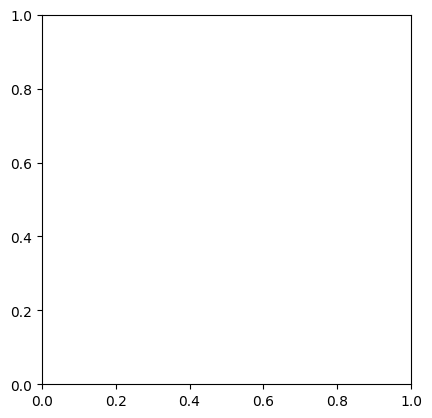

interactive(children=(IntSlider(value=74, description='image_z', max=149), FloatSlider(value=0.5, description=…

<function __main__.display_images_with_alpha(image_z, alpha, fixed, moving)>

In [33]:
#import gui

img_cboard = sitk.CheckerBoard( img_fix, mov_resampled, [8,8,8] )

interact( display_images_with_alpha, 
          image_z = (0,img_fix.GetSize()[2]-1), 
          alpha   = (0.0,1.0,0.05), 
          fixed   = fixed(img_fix), 
          moving  = fixed(img_cboard) )